In [403]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [404]:
from hubmap.visualization import visualize_checkpoint
from hubmap.visualization import visualize_random_image, ImageType
from hubmap.visualization import visualize_image
from hubmap.models import DPT
from hubmap.models.dpt import Backbone

from hubmap.dataset import BaseDataset
from hubmap.data import DATA_DIR
import hubmap.dataset.transforms as T

In [405]:
ckpt = "fct_overfit_mock_img_size_128.pt"

(<Figure size 400x400 with 1 Axes>, <Figure size 400x400 with 1 Axes>)

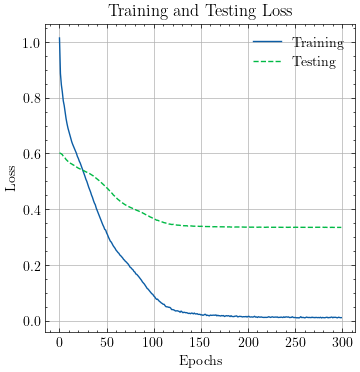

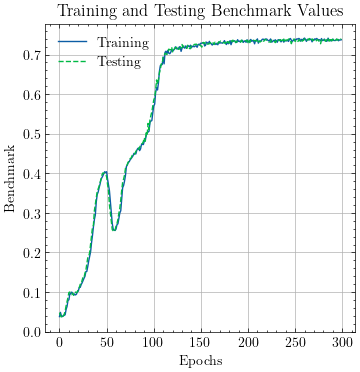

In [406]:
visualize_checkpoint(ckpt)

In [407]:
transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256)),
    ]
)
model_transforms = T.Compose([
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = BaseDataset(DATA_DIR, transform=transforms, with_background=True)
image, target = dataset.get(0, transform=transforms)
target = target[:2, :, :]

In [408]:
import torch

image = torch.load("/home/jflxb/Documents/lmu/HuBMAP/image.pt").squeeze()
target = torch.load("/home/jflxb/Documents/lmu/HuBMAP/target.pt").squeeze()
image.size(), target.size()

(torch.Size([3, 128, 128]), torch.Size([4, 128, 128]))

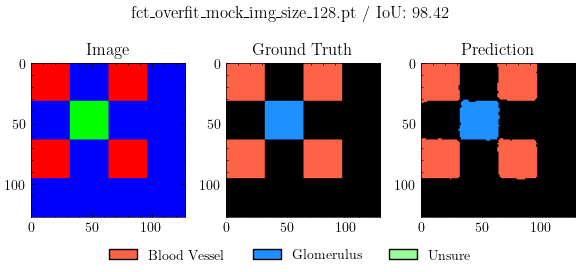

In [418]:
from hubmap.models import FCT
from hubmap.models import init_weights

model = FCT(in_channels=3, num_classes=4)
model.apply(init_weights)

_ = visualize_image(model, ckpt, image, target, transforms=model_transforms, pred_idx=2)

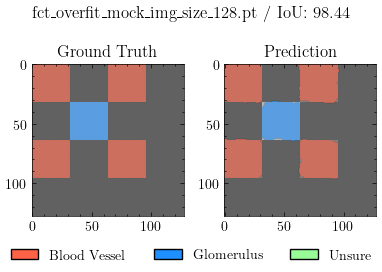

In [419]:
_ = visualize_image(model, ckpt, image, target, transforms=model_transforms, pred_idx=2, overlay=True, grayscale=True, legend=True, title=True)

In [20]:
import torch.nn.functional as F

model = FCT(in_channels=3, num_classes=4)
ckpt = torch.load("/home/jflxb/Documents/lmu/HuBMAP/checkpoints/fct_overfit_mock_img_size_64.pt")
model.load_state_dict(ckpt["model_state_dict"])

model.eval()
with torch.no_grad():
    prediction = model(image.unsqueeze(0))
    prediction = prediction[2]
    # probs = F.softmax(prediction, dim=1)
    # probs = F.sigmoid(prediction)
    # print(probs.size())
    probs = prediction
    # probs, _ = torch.max(probs, dim=1)
    classes = torch.argmax(prediction, dim=1, keepdims=True)
    classes_per_channel = torch.zeros_like(prediction)
    classes_per_channel.scatter_(1, classes, 1)


In [178]:
classes.size()

torch.Size([1, 1, 128, 128])

In [179]:
classes_per_channel.size()

torch.Size([1, 4, 128, 128])

In [180]:
probs.size()

torch.Size([1, 4, 128, 128])

torch.Size([1, 4, 128, 128])


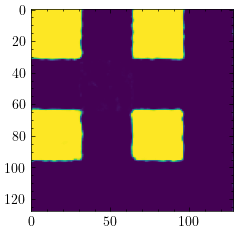

In [181]:
import matplotlib.pyplot as plt

print(probs.size())
plt.imshow(probs.squeeze()[0])

In [ ]:
classes_per_channel.size()

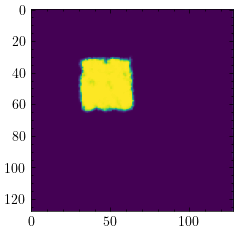

In [182]:
plt.imshow(probs.squeeze()[1])

{0: 'tomato', 1: 'dodgerblue', 2: 'palegreen', 3: 'black'}


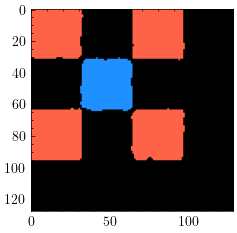

In [50]:
from hubmap.visualization.visualize_mask import mask_to_rgb, mask_to_rgba
import matplotlib.pyplot as plt

cmap = {0: "tomato", 1: "dodgerblue", 2: "palegreen", 3: "black"}

rgbmask = mask_to_rgb(classes_per_channel.squeeze(), color_map=cmap, bg_channel=-1)
plt.imshow(rgbmask.permute(1, 2, 0))

torch.Size([1, 64, 64])


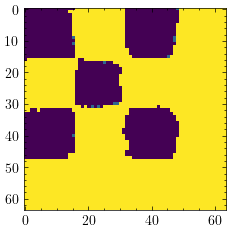

In [122]:
print(classes.size())
plt.imshow(classes.squeeze())


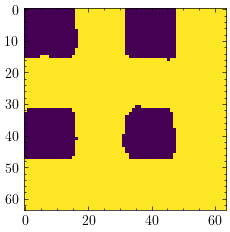

In [133]:
plt.imshow(classes.squeeze())

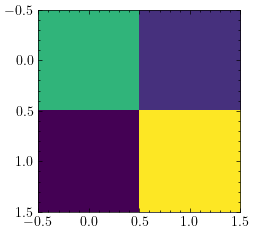

In [158]:
t = torch.tensor([[2.0, 0.5], [0.1, 3.0]])
plt.imshow(t)

In [77]:
classes

tensor([[[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]])

In [110]:
IMG_DIM = 64
box_size = IMG_DIM // 4
image = torch.zeros((1, 3, IMG_DIM, IMG_DIM))
image[:, 0, 0:box_size, 0:box_size] = 1
image[:, 0, 2 * box_size : 3 * box_size, 0:box_size] = 1
image[:, 0, 0:box_size, 2 * box_size : 3 * box_size] = 1
image[:, 0, 2 * box_size : 3 * box_size, 2 * box_size : 3 * box_size] = 1

image[:, 1, box_size:2*box_size, box_size:2*box_size] = 1

image[:, 2, 0:box_size, box_size:2*box_size] = 1
image[:, 2, box_size:2*box_size, 0:box_size] = 1
image[:, 2, box_size:2*box_size, 2*box_size:3*box_size] = 1
image[:, 2, 2*box_size:3*box_size, box_size:2*box_size] = 1
image[:, 2, 0 : 4 * box_size, 3 * box_size : 4 * box_size] = 1
image[:, 2, 3 * box_size : 4 * box_size, 0 : 4 * box_size] = 1


In [174]:
from matplotlib import colors
import torch


def mask_to_rgb(mask: torch.Tensor, color_map: dict, background_channel: int = -1):
    if mask.size(-1) != mask.size(-2):
        raise ValueError("Mask must be square, and in the last to dimensions. Expected: (B, C, H, W) or (C, H, W)")
    if len(mask.size()) != 3:
        raise ValueError("Expecting a 3D tensor. Got: {}".format(mask.size()))
    
    channel_dim = 0
    rgb_mask = torch.zeros((3, mask.size(1), mask.size(2)))
    
    for channel in range(mask.size(channel_dim)):
        if background_channel == channel:
            continue
        color = colors.to_rgb(color_map[channel])
        
        rgb_mask = rgb_mask + mask[channel, :, :] * torch.tensor(color).view(3, 1, 1)
    
    plt.imshow(rgb_mask.permute(1, 2, 0))
    return rgb_mask
    

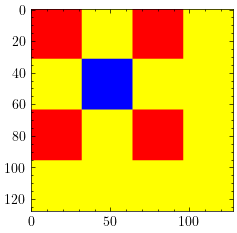

In [175]:
m = mask_to_rgb(image.squeeze(), color_map={0: "red", 1: "blue", 2: "yellow", 3: "green"})

In [109]:
m

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.5020, 0.5020],
         ...,
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [53]:
z = torch.zeros((3, 2, 2))
z[:, 0, 0] = torch.tensor((1.0, 0.0, 0.0))
z[:, 1, 1] = torch.tensor((0.0, 0.5019607843137255, 0.0))

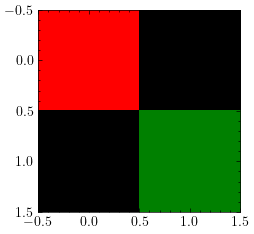

In [54]:
plt.imshow(z.permute(1, 2, 0))

In [24]:
colors.to_rgb('blue')

(0.0, 0.0, 1.0)

In [26]:
image.size(-2)

64

In [27]:
len(image.size())

4

In [35]:
image.size()

torch.Size([1, 4, 64, 64])

In [372]:
target = torch.tensor([
    [
        [
            [0, 0],
            [0, 0]
        ],
        [
            [1, 0],
            [1, 0]
        ]
    ],
    [
        [
            [0, 1],
            [0, 0]
        ],
        [
            [0, 0],
            [1, 1]
        ],
    ],
    [
        [
            [0, 0],
            [0, 0]
        ],
        [
            [0, 0],
            [0, 0]
        ],
    ],
], dtype=torch.float32)

In [379]:
pred = torch.tensor([
    [
        [
            [0, 0],
            [0, 0]
        ],
        [
            [0, 0],
            [1, 0]
        ]
    ],
    [
        [
            [1, 1],
            [1, 0]
        ],
        [
            [0, 0],
            [1, 0]
        ],
    ],
    [
        [
            [0, 0],
            [0, 0]
        ],
        [
            [0, 0],
            [0, 0]
        ],
    ],
], dtype=torch.float32)

In [397]:
print(target.size())
print(pred.size())

torch.Size([3, 2, 2, 2])
torch.Size([3, 2, 2, 2])


In [391]:
from copy import deepcopy

n_classes = target.size(1)
iou_scores = torch.zeros((target.size(0), n_classes))
print(iou_scores.size())

for i in range(n_classes):
    # result = calculate_iou_for_class(i, target, pred)
    cls_idx = i
    T_cls = deepcopy(target[:, cls_idx:cls_idx+1, :, :])
    P_cls = deepcopy(pred[:, cls_idx:cls_idx+1, :, :])
    
    is_special_case = (T_cls.sum(dim=(-2, -1)) == 0)
    T_cls[is_special_case] = torch.logical_not(T_cls[is_special_case]).type(torch.float32)
    P_cls[is_special_case] = torch.logical_not(P_cls[is_special_case]).type(torch.float32)
    intersection = torch.logical_and(T_cls, P_cls).sum(dim=(-2, -1))
    uninon = torch.logical_or(T_cls, P_cls).sum(dim=(-2, -1))
    iou = intersection / uninon

    iou_scores[:, i] = iou.view(-1)

torch.Size([3, 2])


In [396]:
iou_scores

tensor([[1.0000, 0.5000],
        [0.3333, 0.5000],
        [1.0000, 1.0000]])

In [401]:
iou_scores.mean()

tensor(0.7222)

In [394]:
iou_scored_class_reduction = torch.mean(iou_scores, dim=1)

In [395]:
iou_scored_class_reduction

tensor([0.7500, 0.4167, 1.0000])

In [399]:
torch.mean(iou_scored_class_reduction, dim=0)

tensor(0.7222)

In [393]:
iou_scores[:, 1]

tensor([0.5000, 0.5000, 1.0000])

In [325]:
def calculate_iou(T: torch.Tensor, P: torch.Tensor):
    is_special_case = (T.sum(dim=(-2, -1)) == 0)
    T[is_special_case] = torch.logical_not(T[is_special_case]).type(torch.float32)
    P[is_special_case] = torch.logical_not(P[is_special_case]).type(torch.float32)
    intersection = torch.logical_and(T, P).sum(dim=(-2, -1))
    uninon = torch.logical_or(T, P).sum(dim=(-2, -1))
    iou = intersection / uninon
    return iou

In [288]:
calculate_iou(T, P)

tensor([[1.0000],
        [0.5000],
        [0.7500]])

In [289]:
calculate_iou(P, T)

tensor([[1.0000],
        [0.5000],
        [0.7500]])

In [170]:
intersection = torch.logical_and(T == 0, T == P)
# intersection = P == T
intersection_sum = torch.sum(intersection, dim=(-1, -2))
union = torch.logical_or(T != 0, P != 0)
uninon_sum = torch.sum(union, dim=(-1, -2))
iou = intersection_sum / uninon_sum

In [179]:
intersection

tensor([[[[ True,  True],
          [ True,  True]]],


        [[[ True, False],
          [False,  True]]],


        [[[ True,  True],
          [False,  True]]]])

In [166]:
intersection_sum

tensor([[0],
        [1],
        [0]])

In [167]:
uninon_sum

tensor([[0],
        [2],
        [1]])

In [168]:
torch.where(torch.sum(T, dim=(-1, -2)) == 0, 1.0, iou)

tensor([[1.0000],
        [0.5000],
        [1.0000]])